In [1]:
import tenseal as ts


In [2]:
def create_ctx(L = 1, precision = 60, scale = 30):
    poly_mod_degree = 65536
    coeff_mod_bit_sizes = []
    coeff_mod_bit_sizes.append(precision)
    for i in range(L):
        coeff_mod_bit_sizes.append(scale)
    coeff_mod_bit_sizes.append(precision)
    s = sum(coeff_mod_bit_sizes)
    if s <= 27:
        poly_mod_degree = 1024
    elif s <= 54:
        poly_mod_degree = 2048
    elif s <= 109:
        poly_mod_degree = 4096
    elif s <= 218:
        poly_mod_degree = 8192
    elif s <= 438:
        poly_mod_degree = 16384
    elif s <= 881:
        poly_mod_degree = 32768
    ctx = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
    ctx.global_scale = 2**scale
    ctx.generate_galois_keys()
    return ctx

In [3]:
ctx = create_ctx(5)
plain1 = ts.plain_tensor([10])
cipher1 = ts.ckks_tensor(ctx, plain1)

plain2 = ts.plain_tensor([2])
cipher2 = ts.ckks_tensor(ctx, plain2)


In [4]:
cipher1.polyval([1, 1, 1, 1, 1, 1, 1, 2, 1])

In [5]:
1 + cipher2 + cipher2**2 + cipher2**3 + cipher2**4

In [6]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings("ignore") 
# CUSTOMARY IMPORTS
import torch
import torchvision
from  torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

# TRAINING HYPERPARAMETERS: 
n_epochs = 5           # How many passes through the training data  
batch_size = 64  # Training batch size usually in [1,256]

learning_rate = 0.01   # Learning rate for optimizer like SGD usually in [0.001, 0.1]

random_seed = 1  

torch.manual_seed(random_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
import torchvision
import torch
from  torchvision import transforms
#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)



torch.Size([28, 28])


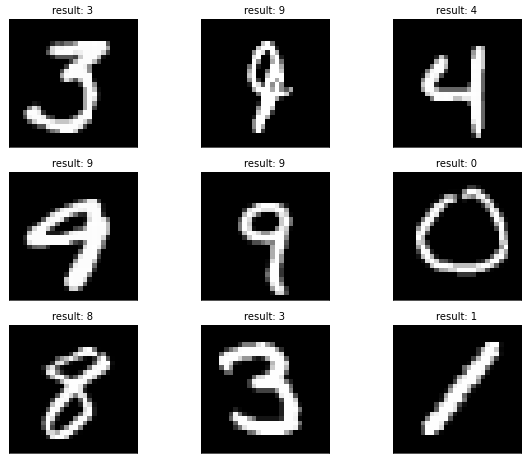

In [8]:
# The enumerate() method adds a counter to an iterable and returns an enumerate object
examples = enumerate(test_loader)
batch_idx, (example_X, example_y) = next(examples)
print(example_X[0][0].shape)
# VISUALIZE SOME EXAMPLES
fig=plt.figure(figsize=(10, 8), dpi=60)
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_X[i][0], cmap='gray')
  plt.title("result: {}".format(example_y[i]))
  plt.xticks([])
  plt.yticks([])

In [9]:
import warnings
warnings.filterwarnings("ignore") 

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    values = []
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1,out_channels = 4,kernel_size = 7,stride = 3,padding = 0)
        
        self.fc1 = nn.Linear(in_features = 8 * 8 * 4,out_features = 64)
        self.fc2 = nn.Linear(in_features = 64,out_features = 10)           # number of classes/digits = 10

    def forward(self, x):
        
        tmp = self.conv1(x)
        # x = F.relu(tmp)
        x = 0.06741737 + tmp * 0.53655024 + tmp * tmp * 0.55253566
        x = x.view(-1, 8 * 8 * 4)     # reshape

        # x = F.relu(self.fc1(x))
        tmp = self.fc1(x)
        x = 0.06741737 + tmp * 0.53655024 + tmp * tmp * 0.55253566
        x = self.fc2(x)
        return x
    def draw_distri(self):
        plt.hist(self.values, bins=100)
        plt.show()

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 4, kernel_size=(7, 7), stride=(3, 3))
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [10]:
criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(net.parameters())
#optimizer = optim.Adam(net.parameters(), lr=0.003)
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.5)

[1/5] Loss: 0.4978, Acc: 0.9688, Test Loss: 0.2722, Test Acc: 0.9281: 100%|██████████| 938/938 [00:10<00:00, 88.10step/s] 
[2/5] Loss: 0.0161, Acc: 0.8750, Test Loss: 0.1788, Test Acc: 0.9497: 100%|██████████| 938/938 [00:09<00:00, 102.80step/s]
[3/5] Loss: 0.0238, Acc: 0.9062, Test Loss: 0.1630, Test Acc: 0.9536: 100%|██████████| 938/938 [00:09<00:00, 102.80step/s]
[4/5] Loss: 0.0744, Acc: 1.0000, Test Loss: 0.1289, Test Acc: 0.9645: 100%|██████████| 938/938 [00:09<00:00, 102.07step/s]
[5/5] Loss: 0.0005, Acc: 0.9688, Test Loss: 0.1220, Test Acc: 0.9666: 100%|██████████| 938/938 [00:09<00:00, 103.74step/s]


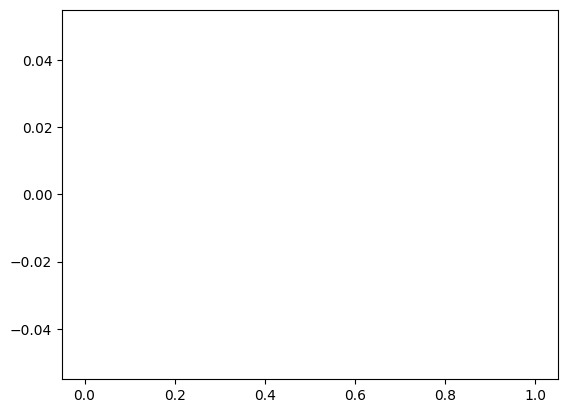

In [11]:
from tqdm import tqdm

#存储训练过程
history = {'Train Loss':[],'Test Loss':[],'Test Accuracy':[]}

for epoch in range(1, n_epochs + 1):
    #构建tqdm进度条
    processBar = tqdm(train_loader,unit = 'step')
    #打开网络的训练模式
    net.train(True)
    #开始对训练集的DataLoader进行迭代
    totalTrainLoss = 0.0
   
    for step,(trainImgs,labels) in enumerate(processBar):
        
        #将图像和标签传输进device中
        trainImgs = trainImgs.to(device)
        labels = labels.to(device)
        
        #清空模型的梯度
        optimizer.zero_grad()
        
        #对模型进行前向推理
        outputs = net(trainImgs)
        
        #计算本轮推理的Loss值
        loss = criterion(outputs,labels)
        #计算本轮推理的准确率
        predictions = torch.argmax(outputs, dim = 1)
        accuracy = torch.sum(predictions == labels)/labels.shape[0]
        
        #进行反向传播求出模型参数的梯度
        loss.backward()
        #使用迭代器更新模型权重
        optimizer.step()

        #将本step结果进行可视化处理
        processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f" % 
                                    (epoch,n_epochs,loss.item(),accuracy.item()))

        totalTrainLoss+= loss
        
        if step == len(processBar)-1:
            correct,totalLoss = 0,0
            totalSize = 0
            net.train(False)
            for testImgs,labels in test_loader:
                testImgs = testImgs.to(device)
                labels = labels.to(device)
                outputs = net(testImgs)
                loss = criterion(outputs,labels)
                predictions = torch.argmax(outputs,dim = 1)
                totalSize += labels.size(0)
                totalLoss += loss
                correct += torch.sum(predictions == labels)
            testAccuracy = correct/totalSize
            testLoss = totalLoss/len(test_loader)
            trainLoss = totalTrainLoss/len(train_loader)
            history['Train Loss'].append(trainLoss.item())
            history['Test Loss'].append(testLoss.item())
            history['Test Accuracy'].append(testAccuracy.item())
            processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f, Test Loss: %.4f, Test Acc: %.4f" % 
                                   (epoch,n_epochs,loss.item(),accuracy.item(),testLoss.item(),testAccuracy.item()))
    processBar.close()
net.draw_distri()

In [ ]:
start = time.time()
correct,totalLoss = 0,0
totalSize = 0
net.train(False)
for testImgs,labels in test_loader:
    testImgs = testImgs.to(device)
    labels = labels.to(device)
    outputs = net(testImgs)
    loss = criterion(outputs,labels)
    predictions = torch.argmax(outputs,dim = 1)
    totalSize += labels.size(0)
    totalLoss += loss
    correct += torch.sum(predictions == labels)
print(f'total size:{totalSize}')
print(f'correct:{correct}')
print(time.time() - start)

In [12]:
def enc_relu(enc_x):
    return enc_x.polyval([0.06741737,0.53655024,0.55253566])

In [13]:
class EncNet:
    def __init__(self, net):
        self.conv1_w = net.conv1.weight.data.view(net.conv1.out_channels, net.conv1.kernel_size[0], net.conv1.kernel_size[1]).tolist()
        self.conv1_b = net.conv1.bias.data.tolist()

        self.fc1_weight = net.fc1.weight.T.data.tolist()
        self.fc1_bias = net.fc1.bias.data.tolist()
        
        self.fc2_weight = net.fc2.weight.T.data.tolist()
        self.fc2_bias = net.fc2.bias.data.tolist()

    def forward(self, enc_x, windows):
        enc_channels = []
        for kernel, bias in zip(self.conv1_w, self.conv1_b):
            y = enc_x.conv2d_im2col(kernel, windows) + bias
            enc_channels.append(y)
        enc_x = ts.CKKSVector.pack_vectors(enc_channels)
        enc_x = enc_relu(enc_x)
        enc_x = enc_x.mm(self.fc1_weight) + self.fc1_bias
        enc_x = enc_relu(enc_x)
        enc_x = enc_x.mm(self.fc2_weight) + self.fc2_bias
        return enc_x
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
        

In [14]:
import time
def enc_test(context, model, test_loader, criterion, kernel_shape, stride):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    cnt = 0
    for data, target in test_loader:
        # Encoding and encryption
        cnt += 1
        if cnt % 10 == 0:
            print(cnt)
        if(cnt >= 100):
            break
        x_enc, windows_nb = ts.im2col_encoding(
            context, data.view(28, 28).tolist(), kernel_shape[0],
            kernel_shape[1], stride
        )
        # Encrypted evaluation
        enc_output = enc_net(x_enc, windows_nb)
        # Decryption of result
        output = enc_output.decrypt()
        output = torch.tensor(output).view(1, -1)

        # compute loss
        loss = criterion(output, target)
        test_loss += loss.item()
        
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        label = target.data[0]
        class_correct[label] += correct.item()
        class_total[label] += 1


    # calculate and print avg test loss
    test_loss = test_loss / sum(class_total)
    print(f'Test Loss: {test_loss:.6f}\n')

    for label in range(10):
        print(
            f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% '
            f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'
        )

    print(
        f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% ' 
        f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'
    )


# Load one element at a time
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
# required for encoding
kernel_shape = net.conv1.kernel_size
stride = net.conv1.stride[0]
print(kernel_shape)
print(stride)

(7, 7)
3


In [15]:
ctx = create_ctx(8)


In [16]:
enc_net = EncNet(net)
enc_test(ctx, enc_net, test_loader, criterion, kernel_shape, stride)

10
20
30
40
50
60
70
80
90
100
Test Loss: 0.118177

Test Accuracy of 0: 93% (15/16)
Test Accuracy of 1: 90% (9/10)
Test Accuracy of 2: 92% (13/14)
Test Accuracy of 3: 100% (11/11)
Test Accuracy of 4: 100% (6/6)
Test Accuracy of 5: 100% (9/9)
Test Accuracy of 6: 100% (4/4)
Test Accuracy of 7: 100% (9/9)
Test Accuracy of 8: 100% (9/9)
Test Accuracy of 9: 100% (11/11)

Test Accuracy (Overall): 96% (96/99)
